📚 ✅ Cell 1 — Import Libraries

In [12]:
# ----------------------------------------------------
# 📌 1️⃣ Import required libraries
# ----------------------------------------------------

# Standard Python libraries
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Limit CPU threads for sklearn

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Sklearn for clustering and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# PyTorch and torchvision for feature extraction
import torch
import torchvision.transforms as transforms
import torchvision.models as models


Cell 2 — Setup Device & Load VGG16

In [13]:
# ----------------------------------------------------
# 📌 2️⃣ Load VGG16 feature extractor
# ----------------------------------------------------

# Detect if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Load VGG16 without classifier (we use only the feature extractor part)
vgg16 = models.vgg16(weights='DEFAULT').features.to(device).eval()

# We won't train VGG16 — we just use it to extract fixed image features.


✅ Using device: cpu


Cell 3 — Define Image Preprocessing

In [14]:
# ----------------------------------------------------
# 📌 3️⃣ Define image transformations
# ----------------------------------------------------

# All images will be resized to 224x224 and normalized to match ImageNet stats.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])


Cell 4 — Extract Features

In [15]:
# ----------------------------------------------------
# 📌 4️⃣ Load images and extract features
# ----------------------------------------------------

folder = "image_dataset"  # Replace with your folder name

image_data = []   # To store feature vectors
image_names = []  # To store image filenames

print("🔍 Extracting features from images...")

for img_name in os.listdir(folder):
    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            # Get features from VGG16
            features = vgg16(img_tensor)
            # Pool to 1x1 output and flatten to vector
            pooled = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
            feature_vector = pooled.view(-1).cpu().numpy()

        image_data.append(feature_vector)
        image_names.append(img_name)

# Convert list to numpy array and ensure float64 for sklearn
image_data = np.array(image_data).astype(np.float64)

print(f"✅ Extracted features for {len(image_data)} images.")


🔍 Extracting features from images...
✅ Extracted features for 61 images.


 Cell 5 — Scale Features

In [16]:
# ----------------------------------------------------
# 📌 5️⃣ Scale features using StandardScaler
# ----------------------------------------------------

# Always scale features for PCA and KMeans.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(image_data)

print(f"✅ Feature matrix shape after scaling: {scaled_features.shape}")


✅ Feature matrix shape after scaling: (61, 512)


Cell 6 — Optional PCA

In [17]:
# ----------------------------------------------------
# 📌 6️⃣ Optional: Apply PCA for dimensionality reduction
# ----------------------------------------------------

# Use PCA to reduce noise and compress features.
pca = PCA(n_components=61)  
features_pca = pca.fit_transform(scaled_features)

print(f"✅ Shape after PCA: {features_pca.shape}")


✅ Shape after PCA: (61, 61)


Cell 7 — Find Optimal k (Elbow Method)

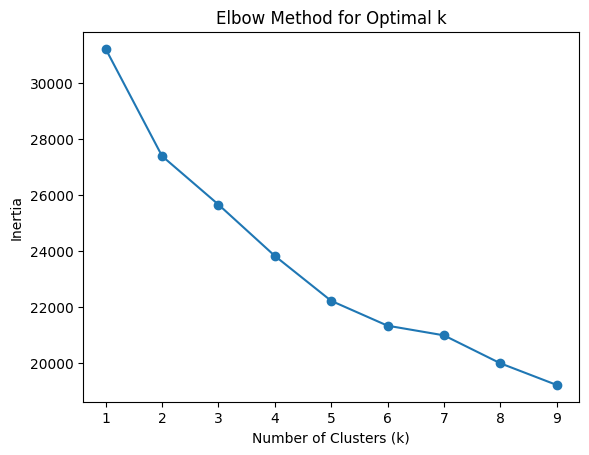

In [18]:
# ----------------------------------------------------
# 📌 7️⃣ Use Elbow Method to find optimal k
# ----------------------------------------------------

inertia = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(features_pca)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


Cell 8 — Final KMeans Clustering

In [19]:
# ----------------------------------------------------
# 📌 8️⃣ Apply final KMeans clustering
# ----------------------------------------------------

k = 5  # Use elbow plot to choose this value

kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(features_pca)

print("✅ KMeans clustering done!")
print(f"Cluster counts: {np.bincount(labels)}")

# Silhouette score to check clustering quality
score = silhouette_score(features_pca, labels)
print(f"Silhouette Score: {score:.3f}")


✅ KMeans clustering done!
Cluster counts: [12 24 13  8  4]
Silhouette Score: 0.090


Cell 9 — Visualize Cluster Samples

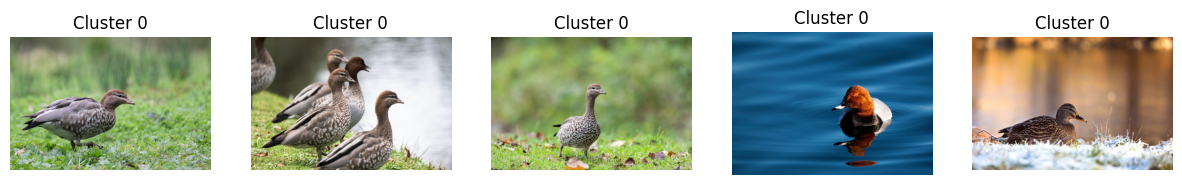

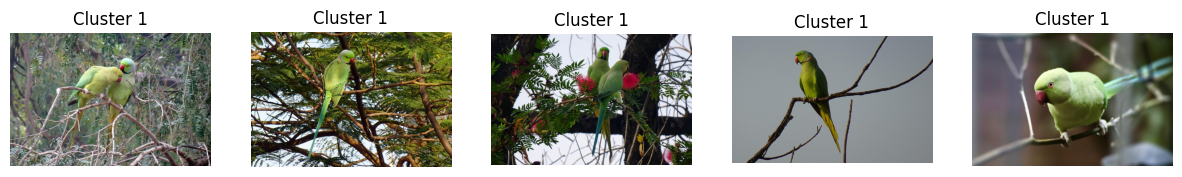

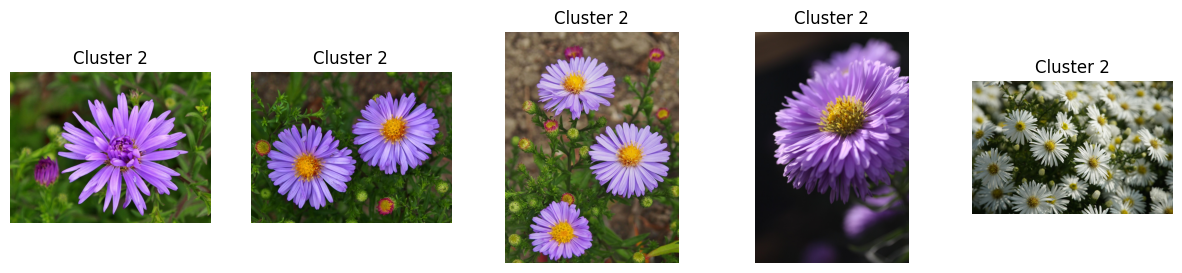

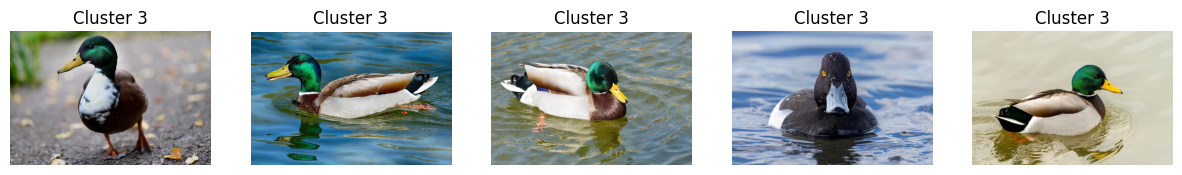

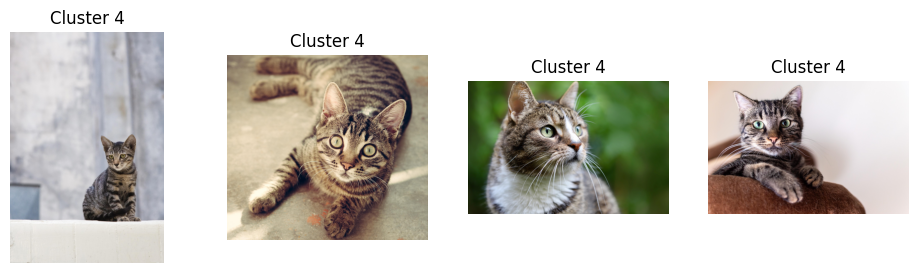

In [20]:
# ----------------------------------------------------
# 📌 9️⃣ Visualize example images from each cluster
# ----------------------------------------------------

def show_cluster_images(cluster_id, count=5):
    indices = np.where(labels == cluster_id)[0][:count]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = Image.open(os.path.join(folder, image_names[idx]))
        plt.subplot(1, count, i + 1)
        plt.imshow(img)
        plt.title(f"Cluster {cluster_id}")
        plt.axis('off')
    plt.show()

# Show samples for each cluster
for cluster_num in range(k):
    show_cluster_images(cluster_num)



📂 Select a new flower image to classify...

✅ The new image belongs to Cluster 4


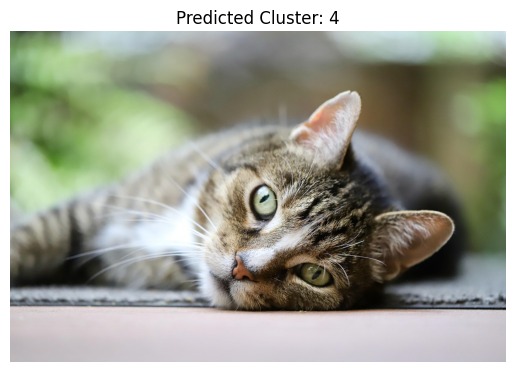

In [22]:
import tkinter as tk
from tkinter import filedialog

print("\n📂 Select a new flower image to classify...")

root = tk.Tk()
root.withdraw()
root.update()

new_img_path = filedialog.askopenfilename(
    title="Select a Flower Image",
    filetypes=[("Image files", "*.jpg *.png *.jpeg")]
)

root.destroy()

if new_img_path:
    new_img = Image.open(new_img_path).convert('RGB')
    new_tensor = transform(new_img).unsqueeze(0).to(device)

    with torch.no_grad():
        new_features = vgg16(new_tensor)
        new_pooled = torch.nn.functional.adaptive_avg_pool2d(new_features, (1, 1))
        new_vector = new_pooled.view(-1).cpu().numpy()

    # ✅ Scale it
    new_scaled = scaler.transform([new_vector])

    # ✅ Apply PCA (must fit only on training data)
    new_pca = pca.transform(new_scaled)   # <<--- This line is the fix

    # ✅ Predict using KMeans trained on PCA features
    new_label = kmeans.predict(new_pca)[0]

    print(f"\n✅ The new image belongs to Cluster {new_label}")

    plt.imshow(new_img)
    plt.title(f"Predicted Cluster: {new_label}")
    plt.axis('off')
    plt.show()

else:
    print("No new image selected.")
